# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno
import numpy as np
import deepcell

### Load the training data

In [2]:
# create folder for this set of experiments
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
npz_name = "Decidua_Shirley_Relabel_Train_256x256"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (441, 256, 256, 3)
y_train.shape: (441, 256, 256, 1)


### Set up filepath constants

In [4]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name + ".npz")

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [6]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = npz_name + '_convolutational_101_rf_512_dense_128_conv'

n_epoch = 10  # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 101  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed=0

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = False  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [7]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

W1205 18:40:08.840744 140525366515520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Train the segmentation transform model

In [8]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),)

X_train shape: (418, 256, 256, 3)
y_train shape: (418, 256, 256, 1)
X_test shape: (23, 256, 256, 3)
y_test shape: (23, 256, 256, 1)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/10


W1205 18:44:59.980221 140525366515520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


417/418 [============================>.] - ETA: 0s - loss: 3.5259 - model_loss: 0.8406 - model_1_loss: 0.8403 - model_2_loss: 0.8376 - model_3_loss: 0.8433 - model_acc: 0.6366 - model_1_acc: 0.6367 - model_2_acc: 0.6409 - model_3_acc: 0.6338
Epoch 00001: val_loss improved from inf to 3.37717, saving model to /data/models/20191113_Decidua_Shirley_Relabel/Decidua_Shirley_Relabel_Train_256x256_convolutational_101_rf_512_dense_128_conv.h5
418/418 [==============================] - 292s 699ms/step - loss: 3.5257 - model_loss: 0.8406 - model_1_loss: 0.8403 - model_2_loss: 0.8376 - model_3_loss: 0.8433 - model_acc: 0.6366 - model_1_acc: 0.6368 - model_2_acc: 0.6409 - model_3_acc: 0.6339 - val_loss: 3.3772 - val_model_loss: 0.8611 - val_model_1_loss: 0.7674 - val_model_2_loss: 0.7813 - val_model_3_loss: 0.8034 - val_model_acc: 0.6771 - val_model_1_acc: 0.7391 - val_model_2_acc: 0.7201 - val_model_3_acc: 0.7230
Epoch 2/10
417/418 [============================>.] - ETA: 0s - loss: 3.1635 - model

### Run the model

#### Make predictions on test data

In [9]:
test_data = np.load(NPZ_DIR + "Decidua_Shirley_Relabel_Test.npz")
(X_test, y_test) = test_data["X"], test_data["y"]

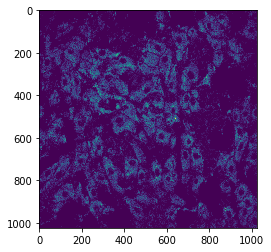

In [10]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0, :, :, 1])

In [11]:
weights_path = os.path.join(MODEL_DIR, conv_model_name + ".h5")
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [12]:
test_images_conv = run_conv_model.predict(X_test[0:1, :, :, :])[-1]
#test_images_fgbg = fgbg_model.predict(X_test)[-1]

#print('watershed transform shape:', test_images.shape)
#print('segmentation mask shape:', test_images_fgbg.shape)

#### Post-processing

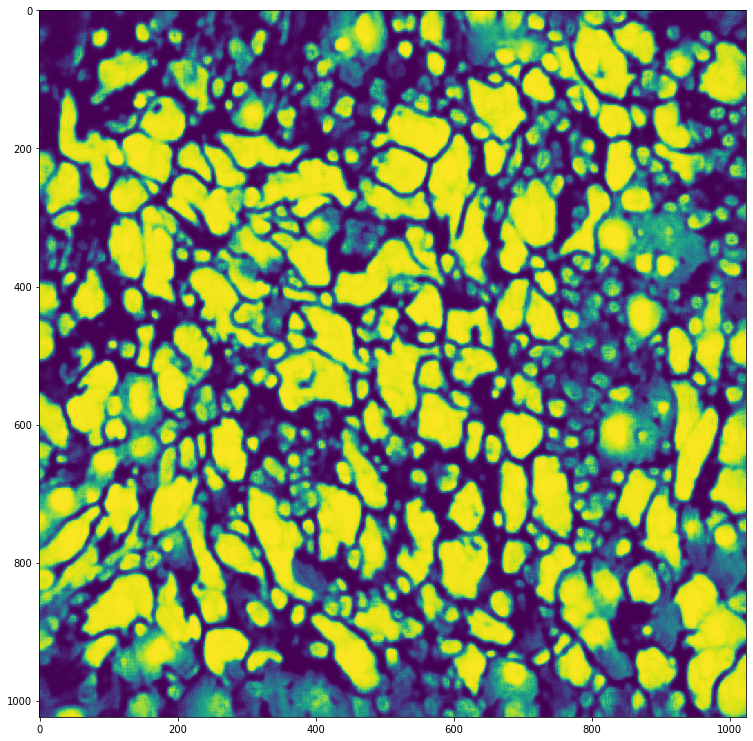

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

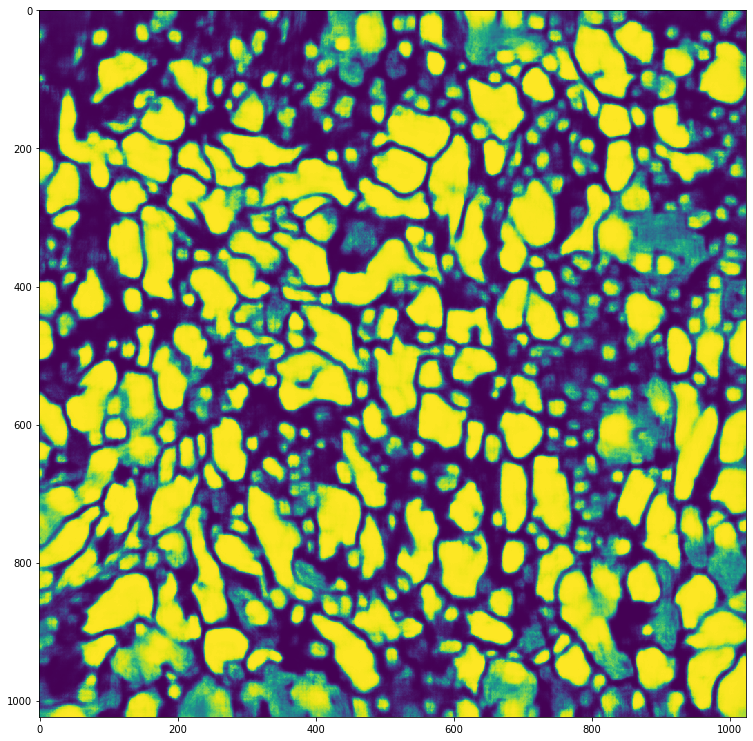

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

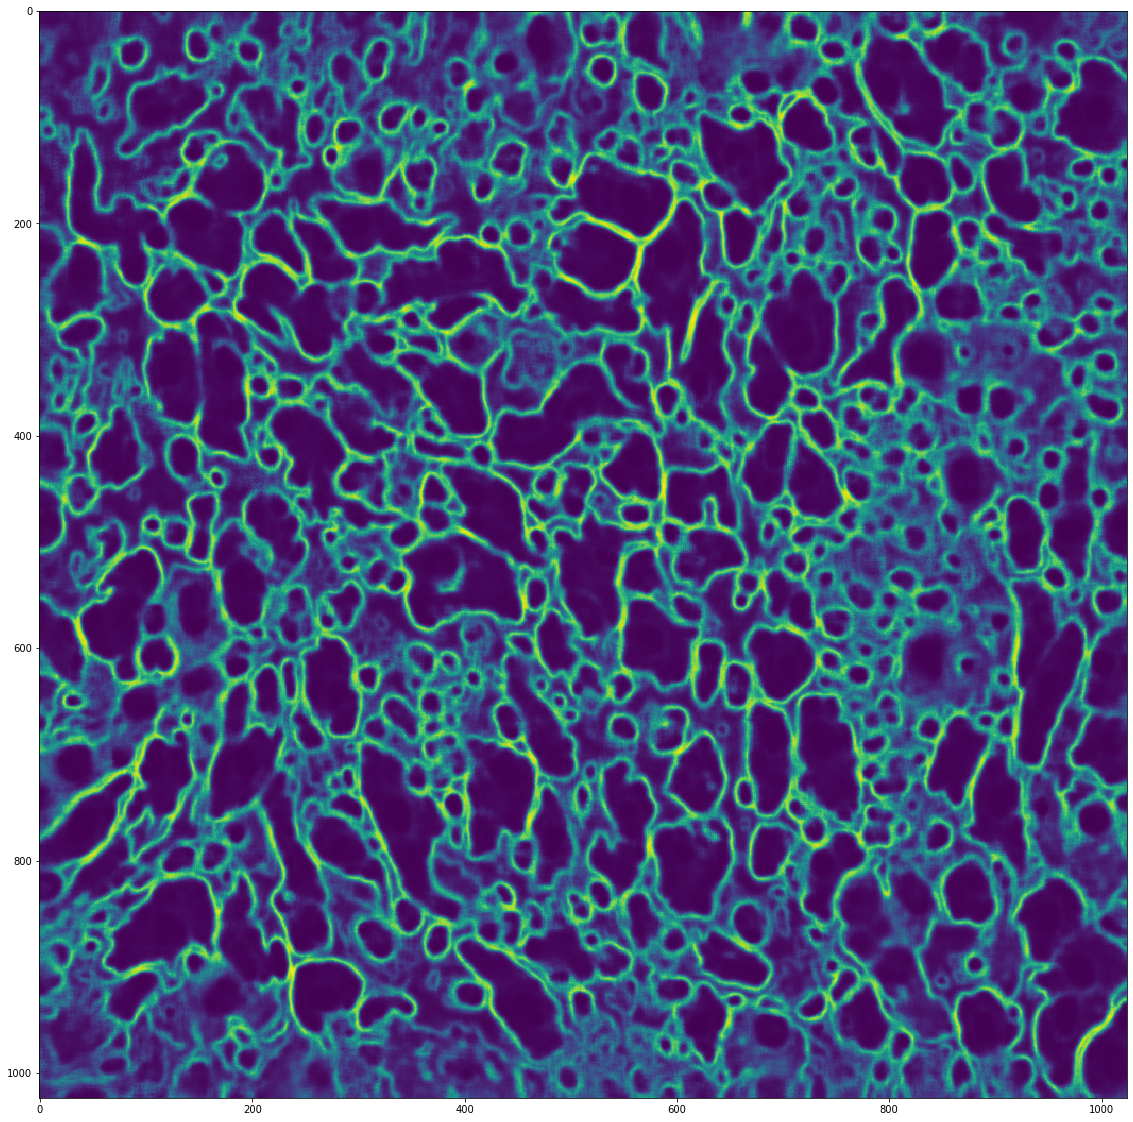

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(test_images_conv[0, :, :, 0])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(test_images_conv[0, :, :, 0])